### Sumário

- Voltando ao problema original
- Algorítimo - Value Iteration 
- Algorítimo - Policy Iteration

### Voltando ao problema original

Nesta parte vamos remover a restrição de movimento adicionada na parte anterior e permitir que se posso mover para todas as direções quando o movimento for possível. Vamos também mudar o mapa do jogo de modo que a solução ótima envolva movimentos para cima e para baixo e para a direita.

In [24]:
import numpy as np
import time
import cliff
import matplotlib.pyplot as plt
from IPython.display import clear_output

-------------------------------------------------
| 0 | 0 | 0 | 0 | 0 | * | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------------------
| 0 | * | 0 | 0 | 0 | * | 0 | 0 | * | * | 0 | 0 | 
-------------------------------------------------
| 0 | * | 0 | 0 | 0 | 0 | 0 | 0 | 0 | * | 0 | 0 | 
-------------------------------------------------
| P | * | * | * | * | * | * | * | * | * | 0 | G | 
-------------------------------------------------


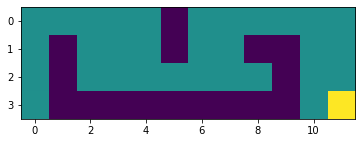

In [25]:
ROWS  = 4
COLS  = 12
START = (3, 0)
GOAL  = (3, 11)

OBSTACLE = [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3,8), (2, 1), (1, 1),
            (2, 9), (2, 9), (2, 9), (2, 9), (2, 9), (2, 9), (2, 9), (2, 9), (2, 9), (3, 0), (0, 5), (1, 8), (3, 9), (1, 9), (1, 5)]

cliff_game = cliff.Cliff(START, GOAL, ROWS, COLS, OBSTACLE)
cliff_game.show()


rewards = np.zeros((ROWS, COLS))
for i in range(0, ROWS):
    for j in range(0, COLS):
        rewards[i, j] = cliff_game.getReward((i,j))
        
plt.imshow(rewards/np.max(rewards))


In [26]:
# Função para calcular o próximo estado a partir da função valor
def get_next_state_given_v_func(state, val_function):
    state_down = (state[0]+1, state[1])
    state_right = (state[0], state[1]+1)
    state_up = (state[0]-1, state[1])
    state_left = (state[0], state[1]-1)
    i = state[0]
    j = state[1]
    next_state = [state_down, state_right, state_up, state_left, state]
    
    if i == 0 and j == 0:
        state_idx = np.argmax(np.r_[val_function[(i+1, j)], val_function[(i, j+1)],
                                    -np.inf, -np.inf])
    # We can go up and left
    elif i == ROWS-1 and j == COLS-1:
        state_idx = 4

    # We can go up and right
    elif i == ROWS-1 and j == 0:
        state_idx = np.argmax(np.r_[-np.inf, val_function[(i, j+1)],
                                    val_function[(i-1, j)], -np.inf])
        
    # We can go down and left
    elif i == 0 and j == COLS-1:
        state_idx = np.argmax(np.r_[val_function[(i+1, j)], -np.inf, 
                                    -np.inf, val_function[(i, j-1)]])
        
    # We can move down, left and right
    elif i == 0:
        state_idx = np.argmax(np.r_[val_function[(i+1, j)], val_function[(i, j+1)],
                                    -np.inf, val_function[(i, j-1)]])
        
    # We can move up, down and right
    elif j == 0:
        state_idx = np.argmax(np.r_[val_function[(i+1, j)], val_function[(i, j+1)],
                                    val_function[(i-1, j)],  -np.inf])
        
    # We can go up, left and right
    elif i == ROWS-1:
        state_idx = np.argmax(np.r_[-np.inf, val_function[(i, j+1)],
                                    val_function[(i-1, j)], val_function[(i, j-1)]])
        
    # We can go up, down and left
    elif j == COLS-1:
        state_idx = np.argmax(np.r_[val_function[(i+1, j)], -np.inf,
                                    val_function[(i-1, j)], val_function[(i, j-1)]])

    # We can move in all directions
    else:
        state_idx = np.argmax(np.r_[val_function[(i+1, j)], val_function[(i, j+1)],
                                    val_function[(i-1, j)], val_function[(i, j-1)]])
                                                           
    return next_state[state_idx] 

In [5]:
def value_iteration(rows, cols, gamma, rewards, epsilon_th=0.1, max_iter=50):
    
    val_function_past = np.zeros((rows, cols))
    val_function = np.zeros((rows, cols))
    
    it = 0
    epsilon = 1e3
    stop = False
    while it < max_iter and not stop:
        for i in reversed(range(0, ROWS)):
            for j in reversed(range(0, COLS)):
                # We can only move down or right
                if i == 0 and j == 0:
                    val_function[(i, j)] = gamma*max(val_function[(i+1, j)], val_function[(i, j+1)]) + rewards[i, j]

                # End game, no moves
                elif i == ROWS-1 and j == COLS-1:
                    val_function[(i, j)] = rewards[i, j]

                # We can go up and right
                elif i == ROWS-1 and j == 0:
                    val_function[(i, j)] = gamma*max(val_function[(i-1, j)], val_function[(i, j+1)]) + rewards[i, j]
                    
                # We can go down and left
                elif i == 0 and j == COLS-1:
                    val_function[(i, j)] = gamma*max(val_function[(i+1, j)], val_function[(i, j-1)]) + rewards[i, j]
                    
                # We can move down, left and right
                elif i == 0:
                    val_function[(i, j)] = gamma*max(val_function[(i+1, j)], val_function[(i, j-1)],
                                                     val_function[(i, j+1)]) + rewards[i, j]
                    
                # We can move up, down and right
                elif j == 0:
                    val_function[(i, j)] = gamma*max(val_function[(i+1, j)], val_function[(i, j+1)],
                                                     val_function[(i-1, j)]) + rewards[i, j]
                    
                # We can go up, left and right
                elif i == ROWS-1:
                    val_function[(i, j)] = gamma*max(val_function[(i, j-1)], val_function[(i-1, j)],
                                                     val_function[(i, j+1)]) + rewards[i, j]
                    
                # We can go up, down and left
                elif j == COLS-1:
                    val_function[(i, j)] = gamma*max(val_function[(i, j-1)], val_function[(i+1, j)],
                                                     val_function[(i-1, j)]) + rewards[i, j]
                    
                # We can move in all directions
                else:
                    val_function[(i, j)] = gamma*max(val_function[(i+1, j)], val_function[(i, j+1)],
                                                     val_function[(i-1, j)], val_function[(i, j-1)]) + rewards[i, j]
        
        it = it + 1
        if np.linalg.norm(val_function - val_function_past) < epsilon_th*(1-gamma)/(2*gamma):
            stop = True
            
        val_function_past = np.copy(val_function)
        
    return val_function
    

###  Algorítimo - Value Iteration 

Diferente da parte anterior agora o a função valor de um estado também dependo dos estados a esquerda e do estado acima, pois essas ações são possívels, isso impede que possamos resolver o problema com backward dynamic programing (há função valor depende também dos valores de trás e estes dos valores da frente). 

Uma maneira de resolver o problema nessas condições e calcular a função de forma iterativa. 

Para isso usaremos o algorítmo chamado de Value Iteration que consiste.

- 1 - Inicia a função valor com 0 para todos os estados.
- 2 - Passar pelos estados calculando o valor da função valor e assumindo que a função valor dos estados vizinhos esta correta.
- 3 - Repetir o passo 2 até que a função de todos os estados convirja para um valor.


*Mais detalhes no livro: Aproximate Dynamic Programming, Warren B. Powell



In [27]:
# Initializing empty value function
gamma = 0.97
val_function = np.zeros((ROWS, COLS))

In [28]:
val_function = value_iteration(ROWS, COLS, gamma, rewards, epsilon_th=0.1)

In [29]:
state = (3, 0)
path = [state]
while state != (ROWS-1, COLS-1):
    state = get_next_state_given_v_func(state, val_function)
    path.append(state)
    

In [30]:
# Plot optimum trajectory
for state in path:
    cliff_game.setState(state)
    cliff_game.show()
    time.sleep(0.4)
    clear_output(True)


-------------------------------------------------
| 0 | 0 | 0 | 0 | 0 | * | 0 | 0 | 0 | 0 | 0 | 0 | 
-------------------------------------------------
| 0 | * | 0 | 0 | 0 | * | 0 | 0 | * | * | 0 | 0 | 
-------------------------------------------------
| 0 | * | 0 | 0 | 0 | 0 | 0 | 0 | 0 | * | 0 | 0 | 
-------------------------------------------------
| S | * | * | * | * | * | * | * | * | * | 0 | P | 
-------------------------------------------------


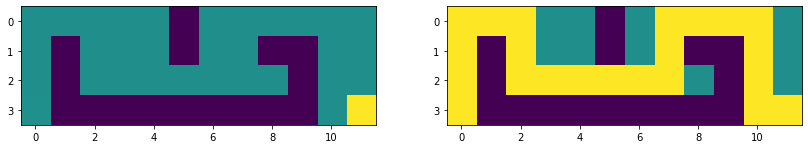

In [31]:
path_highlight = np.copy(rewards)
for state in path:
    path_highlight[state[0], state[1]] = 1000

fig, axs = plt.subplots(1, 2, figsize=(14, 18))
axs[0].imshow(rewards)
axs[1].imshow(path_highlight)

Vemos que o algorítimo foi capaz de calcular uma função valor de modo que transitando para o estado de maior função valor percorremos o caminho ótimo esperado. Vamos verificar graficamente os valores dessa função valor junto com a matriz transição de estado.

In [33]:
def extract_state_transition_matrix(val_function, get_next_state=None):
    # Extract policy transition matrix from value function
    policy_transition = np.zeros((ROWS*COLS, ROWS*COLS))
    
    for i in range(0, ROWS):
        for j in range(0, COLS):
            if i == ROWS-1 and j == COLS-1:
                continue
            next_state = get_next_state((i, j), val_function)
            policy_transition[i*COLS+j, next_state[0]*COLS+next_state[1]] = 1
    
    return policy_transition

In [34]:
pt = extract_state_transition_matrix(val_function, get_next_state_given_v_func)

Text(0.5, 1.0, 'Policy from Value Iteration')

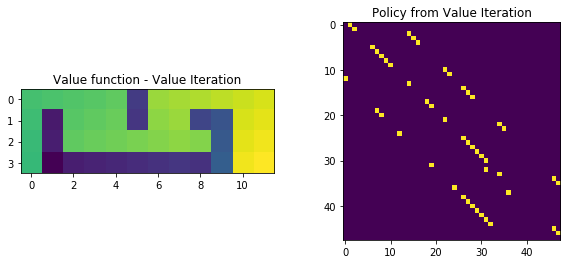

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(val.reshape(ROWS, COLS))
axs[0].set_title("Value function - Value Iteration")
axs[1].imshow(pt)
axs[1].set_title("Policy from Value Iteration")

###  Algorítimo - Policy Iteration

Neste algorítmo trabalhamos diretamente com a política de decisoes adotadas até converjirmos para a política ótima. Para seguimos os seguintes passos.

- 1 - Inicia-se com uma política qualquer
- 2 - Calcula-se a função valor para a política escolhida (diferente da função valor da política ótima)
- 3 - Utiliza-se a função valor para gerar uma nova política, no caso a política otíma gerar pela função valor calculada no método 2.
- 4 - Repetimos os passos 2 e 3 até converjirmos para uma política estável.


In [37]:
pt_init = np.eye(ROWS*COLS, ROWS*COLS)
np.random.shuffle(pt_init)

In [38]:
def policy_iteration(pt, gamma, rewards, epsilon_th=0.1, max_iter=50):
    val_past = np.zeros((ROWS*COLS, 1))
    
    it = 0
    stop = False
    while it < max_iter and not stop:
        
        # Evaluate policy value function
        val = np.dot(np.linalg.pinv(np.eye(ROWS*COLS) - gamma*pt), np.reshape(rewards, (ROWS*COLS, 1)))
        
        # Extract new policy from value function
        pt = extract_state_transition_matrix(val_function, get_next_state_given_v_func)
                
        # Check stop criteria
        if np.linalg.norm(val - val_past) < epsilon_th:
            stop = True

        val_past = np.copy(val)
        it = it + 1
    
    return pt, val
        
    

In [41]:
# Política final e última função valor calculada
pt, val = policy_iteration(pt, gamma, rewards)

Text(0.5, 1.0, 'Value function calculated by policy iteration')

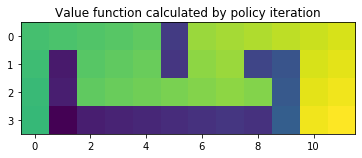

In [40]:
plt.imshow(val.reshape(ROWS, COLS))
plt.title("Value function calculated by policy iteration")

Vemos que a última função valor calculada foi exatamente a mesma obtida pelo método Value Iteration.  Vejamos por fim a política inicial e política de final.

Text(0.5, 1.0, 'Calculated policy state transition matrix')

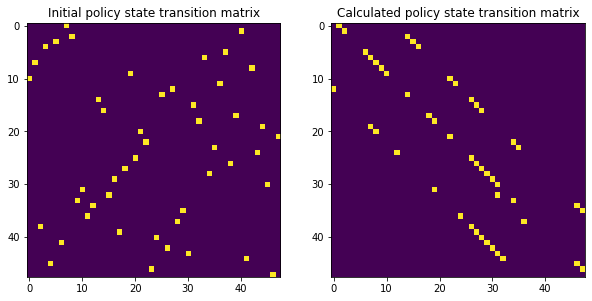

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].imshow(pt_init)
axs[0].set_title("Initial policy state transition matrix")
axs[1].imshow(pt)
axs[1].set_title("Calculated policy state transition matrix")